In [9]:
# 1. Import libraries and setup 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ML Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, RFE, VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC



# Additional utilities
import joblib
import pickle
from datetime import datetime
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import shap

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

print(f"Model Training started at: {datetime.now()}")





Model Training started at: 2025-12-12 09:48:14.661107


In [10]:
# 2. Load Processed Data 

try:
    df = pd.read_parquet('cleaned_agricultural_data.csv')
except:
    df = pd.read_csv('cleaned_agricultural_data.csv')


# Load EDA results for reference
try:
    with open('eda_analysis_results.pkl', 'rb') as f:
        eda_results = pickle.load(f)
except:
    eda_results = {}

print(f"Dataset Shape: {df.shape}")
print(f"Memory Usage: {df.memory_usage().sum() / 1024**2:.2f} MB")

#Display first few rows 
print("\nDataset Preview:")
print(df.head())



Dataset Shape: (2484, 118)
Memory Usage: 2.24 MB

Dataset Preview:
   Dist Code  Year  State Code      State Name   Dist Name  \
0         52  2010           1  Andhra Pradesh  Ananthapur   
1         52  2011           1  Andhra Pradesh  Ananthapur   
2         52  2012           1  Andhra Pradesh  Ananthapur   
3         52  2013           1  Andhra Pradesh  Ananthapur   
4         52  2014           1  Andhra Pradesh  Ananthapur   

   RICE AREA (1000 ha)  RICE PRODUCTION (1000 tons)  RICE YIELD (Kg per ha)  \
0                59.80                       171.40                 2866.22   
1                48.67                       120.07                 2467.02   
2                29.05                        76.45                 2631.67   
3                40.40                        87.94                 2176.73   
4                29.21                        82.53                 2825.40   

   WHEAT AREA (1000 ha)  WHEAT PRODUCTION (1000 tons)  \
0                  0.13     

In [11]:
# 3. Problem Formulation and Target Definition

def define_problems(df):
    """
    Define multiple prediction problems for the agricultural dataset
    Returns dictionary with problem definitions and target columns
    """
    
    problems = {}
    
    # Problem 1: Overall Yield Prediction (Regression)
    problems['yield_prediction'] = {
        'type': 'regression',
        'target': 'OVERALL_YIELD_Kg_per_ha',
        'description': 'Predict overall agricultural yield based on various features',
        'metrics': ['RMSE', 'MAE', 'R2']
    }
    
    # Problem 2: Crop-Specific Yield Prediction (Rice)
    problems['rice_yield_prediction'] = {
        'type': 'regression',
        'target': 'RICE YIELD (Kg per ha)',
        'description': 'Predict rice yield specifically',
        'metrics': ['RMSE', 'MAE', 'R2']
    }
    
    # Problem 3: High-Yield District Classification (Binary)
    # Define high yield as above median overall yield
    median_yield = df['OVERALL_YIELD_Kg_per_ha'].median()
    problems['high_yield_classification'] = {
        'type': 'classification',
        'target': 'HIGH_YIELD_FLAG',
        'description': 'Classify districts as high-yield vs low-yield',
        'metrics': ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC-ROC']
    }
    
    # Problem 4: Productivity Cluster Prediction (Multi-class)
    if 'Cluster' in eda_results.get('district_clusters', pd.DataFrame()):
        problems['cluster_prediction'] = {
            'type': 'multiclass',
            'target': 'CLUSTER',
            'description': 'Predict district productivity cluster',
            'metrics': ['Accuracy', 'F1_macro', 'F1_micro']
        }
    
    # Problem 5: Year-over-Year Yield Change (Regression)
    if 'OVERALL_YIELD_Kg_per_ha_YoY_Growth' in df.columns:
        problems['yoy_change_prediction'] = {
            'type': 'regression',
            'target': 'OVERALL_YIELD_Kg_per_ha_YoY_Growth',
            'description': 'Predict year-over-year yield change',
            'metrics': ['RMSE', 'MAE', 'R2']
        }
    
    return problems

problems = define_problems(df)
print("Defined Prediction Problems:")
print("=" * 80)
for prob_name, prob_config in problems.items():
    print(f"\n{prob_name.upper()}:")
    print(f"  Type: {prob_config['type']}")
    print(f"  Target: {prob_config['target']}")
    print(f"  Description: {prob_config['description']}")



        

    





Defined Prediction Problems:

YIELD_PREDICTION:
  Type: regression
  Target: OVERALL_YIELD_Kg_per_ha
  Description: Predict overall agricultural yield based on various features

RICE_YIELD_PREDICTION:
  Type: regression
  Target: RICE YIELD (Kg per ha)
  Description: Predict rice yield specifically

HIGH_YIELD_CLASSIFICATION:
  Type: classification
  Target: HIGH_YIELD_FLAG
  Description: Classify districts as high-yield vs low-yield

CLUSTER_PREDICTION:
  Type: multiclass
  Target: CLUSTER
  Description: Predict district productivity cluster

YOY_CHANGE_PREDICTION:
  Type: regression
  Target: OVERALL_YIELD_Kg_per_ha_YoY_Growth
  Description: Predict year-over-year yield change


In [12]:
# 4. Data Preparation for ML


def prepare_ml_data(df, problems):
    """
    Prepare data for machine learning by creating target variables
    and feature sets for each problem
    """
    
    ml_data = {}
    
    # Create a copy for modification
    df_ml = df.copy()
    
    # Problem 1: Overall Yield Prediction
    target1 = problems['yield_prediction']['target']
    if target1 in df_ml.columns:
        # Drop rows with missing target
        df_yield = df_ml.dropna(subset=[target1]).copy()
        ml_data['yield_prediction'] = {
            'X': df_yield.drop(columns=[target1]),
            'y': df_yield[target1],
            'problem_type': 'regression'
        }
    
    # Problem 2: Rice Yield Prediction
    target2 = problems['rice_yield_prediction']['target']
    if target2 in df_ml.columns:
        df_rice = df_ml.dropna(subset=[target2]).copy()
        ml_data['rice_yield_prediction'] = {
            'X': df_rice.drop(columns=[target2]),
            'y': df_rice[target2],
            'problem_type': 'regression'
        }
    
    # Problem 3: High-Yield Classification
    median_yield = df_ml['OVERALL_YIELD_Kg_per_ha'].median()
    df_ml['HIGH_YIELD_FLAG'] = (df_ml['OVERALL_YIELD_Kg_per_ha'] > median_yield).astype(int)
    
    df_class = df_ml.dropna(subset=['HIGH_YIELD_FLAG']).copy()
    ml_data['high_yield_classification'] = {
        'X': df_class.drop(columns=['HIGH_YIELD_FLAG']),
        'y': df_class['HIGH_YIELD_FLAG'],
        'problem_type': 'classification'
    }
    
    # Problem 4: Cluster Prediction (if available)
    if 'cluster_prediction' in problems:
        cluster_df = eda_results.get('district_clusters', pd.DataFrame())
        if not cluster_df.empty and 'Cluster' in cluster_df.columns:
            # Merge cluster information
            cluster_mapping = cluster_df.set_index(['State Name', 'Dist Name'])['Cluster'].to_dict()
            df_ml['CLUSTER'] = df_ml.apply(
                lambda row: cluster_mapping.get((row['State Name'], row['Dist Name']), -1),
                axis=1
            )
            
            df_cluster = df_ml[df_ml['CLUSTER'] != -1].copy()
            ml_data['cluster_prediction'] = {
                'X': df_cluster.drop(columns=['CLUSTER']),
                'y': df_cluster['CLUSTER'],
                'problem_type': 'multiclass'
            }
    
    # Problem 5: YoY Change Prediction
    if 'yoy_change_prediction' in problems:
        target5 = problems['yoy_change_prediction']['target']
        if target5 in df_ml.columns:
            df_yoy = df_ml.dropna(subset=[target5]).copy()
            ml_data['yoy_change_prediction'] = {
                'X': df_yoy.drop(columns=[target5]),
                'y': df_yoy[target5],
                'problem_type': 'regression'
            }
    
    return ml_data

ml_data = prepare_ml_data(df, problems)

print("\nML Data Preparation Summary:")
print("=" * 80)
for prob_name, data_dict in ml_data.items():
    print(f"\n{prob_name.upper()}:")
    print(f"  Samples: {len(data_dict['y'])}")
    print(f"  Features: {data_dict['X'].shape[1]}")
    print(f"  Problem Type: {data_dict['problem_type']}")
    print(f"  Target Distribution:")
    if data_dict['problem_type'] == 'classification':
        print(data_dict['y'].value_counts(normalize=True).round(3))
    elif data_dict['problem_type'] == 'regression':
        print(f"    Mean: {data_dict['y'].mean():.2f}, Std: {data_dict['y'].std():.2f}")



ML Data Preparation Summary:

YIELD_PREDICTION:
  Samples: 2481
  Features: 117
  Problem Type: regression
  Target Distribution:
    Mean: 1784.72, Std: 900.71

RICE_YIELD_PREDICTION:
  Samples: 2484
  Features: 117
  Problem Type: regression
  Target Distribution:
    Mean: 2078.30, Std: 1115.62

HIGH_YIELD_CLASSIFICATION:
  Samples: 2484
  Features: 118
  Problem Type: classification
  Target Distribution:
HIGH_YIELD_FLAG
0    0.501
1    0.499
Name: proportion, dtype: float64

CLUSTER_PREDICTION:
  Samples: 2484
  Features: 119
  Problem Type: multiclass
  Target Distribution:

YOY_CHANGE_PREDICTION:
  Samples: 2170
  Features: 119
  Problem Type: regression
  Target Distribution:
    Mean: 0.19, Std: 1.74


In [13]:
# 5. Feature Engineering for ML


def create_ml_features(X_df):
    """
    Create additional features specifically for machine learning
    """
    
    X_processed = X_df.copy()
    
    # 1. Create temporal features
    if 'Year' in X_processed.columns:
        X_processed['DECADE'] = (X_processed['Year'] // 10) * 10
        X_processed['YEAR_SIN'] = np.sin(2 * np.pi * X_processed['Year'] / 10)
        X_processed['YEAR_COS'] = np.cos(2 * np.pi * X_processed['Year'] / 10)
    
    # 2. Create interaction features
    if all(col in X_processed.columns for col in ['TOTAL_AREA_1000_ha', 'TOTAL_PRODUCTION_1000_tons']):
        X_processed['AREA_PRODUCTION_RATIO'] = (
            X_processed['TOTAL_PRODUCTION_1000_tons'] / 
            X_processed['TOTAL_AREA_1000_ha'].replace(0, np.nan)
        )
    
    # 3. Create polynomial features for key numerical columns
    key_numeric_cols = [
        'TOTAL_AREA_1000_ha', 'TOTAL_PRODUCTION_1000_tons',
        'CROP_DIVERSIFICATION_INDEX', 'PRODUCTIVITY_EFFICIENCY'
    ]
    
    for col in key_numeric_cols:
        if col in X_processed.columns:
            X_processed[f'{col}_SQ'] = X_processed[col] ** 2
            X_processed[f'{col}_LOG'] = np.log1p(np.abs(X_processed[col]))
    
    # 4. Create statistical aggregation features
    # Group by state and create state-level statistics
    if 'State Name' in X_processed.columns:
        state_stats = X_processed.groupby('State Name').agg({
            'TOTAL_AREA_1000_ha': ['mean', 'std', 'min', 'max'],
            'TOTAL_PRODUCTION_1000_tons': ['mean', 'std']
        }).round(2)
        
        state_stats.columns = ['STATE_' + '_'.join(col).strip() for col in state_stats.columns]
        state_stats = state_stats.reset_index()
        
        X_processed = X_processed.merge(state_stats, on='State Name', how='left')
    
    # 5. Create lag features for time-series analysis
    if 'Year' in X_processed.columns and 'Dist Name' in X_processed.columns:
        # Sort by district and year
        X_processed = X_processed.sort_values(['Dist Name', 'Year'])
        
        # Create 1-year lag for key features
        lag_cols = ['TOTAL_PRODUCTION_1000_tons', 'OVERALL_YIELD_Kg_per_ha']
        for col in lag_cols:
            if col in X_processed.columns:
                X_processed[f'{col}_LAG1'] = X_processed.groupby('Dist Name')[col].shift(1)
                X_processed[f'{col}_CHANGE'] = X_processed[col] - X_processed[f'{col}_LAG1']
    
    # 6. Create seasonality features
    if 'Year' in X_processed.columns:
        X_processed['IS_EVEN_YEAR'] = (X_processed['Year'] % 2 == 0).astype(int)
        X_processed['YEAR_QUARTER'] = ((X_processed['Year'] % 4) + 1).astype(int)
    
    return X_processed

# Apply feature engineering to all problems
for prob_name, data_dict in ml_data.items():
    if prob_name in ['yield_prediction', 'rice_yield_prediction', 'yoy_change_prediction']:
        ml_data[prob_name]['X'] = create_ml_features(data_dict['X'])

print("\nFeature Engineering Completed:")
print("=" * 80)
for prob_name, data_dict in ml_data.items():
    if prob_name in ['yield_prediction', 'rice_yield_prediction', 'yoy_change_prediction']:
        original_features = df.shape[1]
        new_features = data_dict['X'].shape[1]
        print(f"{prob_name}: {original_features} → {new_features} features")



Feature Engineering Completed:
yield_prediction: 118 → 139 features
rice_yield_prediction: 118 → 141 features
yoy_change_prediction: 118 → 143 features


In [14]:
# 6. Feature Selection Pipeline


def create_feature_selection_pipeline(X, y, problem_type='regression', n_features=50):
    """
    Feature selection pipeline with strict protection against:
    - inf values
    - overflow
    - zero-variance scaling bugs
    """

    #  PRE-CLEAN RAW VALUES
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.applymap(lambda v: np.nan if isinstance(v, (int, float)) and (abs(v) > 1e308) else v)

    # Split columns
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()

    # Remove ID-like columns
    exclude_cols = ['Year', 'Dist Code', 'State Code', 'Dist Name', 'State Name']
    numerical_cols = [col for col in numerical_cols if col not in exclude_cols]

    # Remove zero-variance cols BEFORE scaling to avoid divide-by-zero
    zero_var = [col for col in numerical_cols if X[col].nunique() <= 1]
    if len(zero_var) > 0:
        numerical_cols = [c for c in numerical_cols if c not in zero_var]

    # Numerical pipeline
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # Categorical pipeline
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    # Combine preprocessing
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols),
        ],
        remainder='drop'
    )

    # Feature selection pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('variance_threshold', VarianceThreshold(threshold=0.0001)),
        ('feature_selection', SelectKBest(
            score_func=f_regression if problem_type == 'regression' else mutual_info_regression,
            k=min(n_features, 2000)
        ))
    ])

    return pipeline


def select_features(ml_data, n_features=50):
    selected_data = {}

    for prob_name, data_dict in ml_data.items():
        print(f"\nProcessing {prob_name}...")

        X = data_dict['X'].copy()
        y = data_dict['y']
        problem_type = data_dict['problem_type']

        # Hard clean raw X
        X = X.replace([np.inf, -np.inf], np.nan)
        X = X.applymap(lambda v: np.nan if isinstance(v, (int, float)) and (abs(v) > 1e308) else v)

        try:
            fs_pipeline = create_feature_selection_pipeline(
                X, y, problem_type, n_features
            )

            # Fit-transform safely
            X_transformed = fs_pipeline.named_steps['preprocessor'].fit_transform(X)

            # -------- POST-CLEAN TRANSFORMED DATA --------
            X_transformed = np.nan_to_num(X_transformed, nan=0.0, posinf=0.0, neginf=0.0)

            # Replace preprocessor output with cleaned version
            fs_pipeline.named_steps['preprocessor'].transform = lambda _X: X_transformed

            # Now run variance threshold + KBest
            X_selected = fs_pipeline.named_steps['variance_threshold'].fit_transform(X_transformed)
            X_selected = fs_pipeline.named_steps['feature_selection'].fit_transform(X_selected, y)

            # Feature names
            preprocessor = fs_pipeline.named_steps['preprocessor']
            feature_names = []

            # Numerical
            num_features = preprocessor.transformers_[0][2]
            feature_names.extend(num_features)

            # Categorical
            cat_features = preprocessor.transformers_[1][2]
            if len(cat_features) > 0:
                cat_pipeline = preprocessor.transformers_[1][1]
                onehot = cat_pipeline.named_steps['onehot']
                cat_feature_names = onehot.get_feature_names_out(cat_features)
                feature_names.extend(cat_feature_names)

            # Selected
            selector = fs_pipeline.named_steps['feature_selection']
            selected_indices = selector.get_support(indices=True)
            selected_feature_names = [feature_names[i] for i in selected_indices]

            selected_data[prob_name] = {
                'X': X_selected,
                'y': y.values,
                'feature_names': selected_feature_names,
                'problem_type': problem_type,
                'fs_pipeline': fs_pipeline
            }

            print(f"  Selected {len(selected_feature_names)} features")
            print(f"  Top 10 features: {selected_feature_names[:10]}")

        except Exception as e:
            print(f"  Error in feature selection: {str(e)}")
            selected_data[prob_name] = {
                'X': X.values,
                'y': y.values,
                'feature_names': X.columns.tolist(),
                'problem_type': problem_type,
                'fs_pipeline': None
            }

    return selected_data


# Run feature selection
selected_data = select_features(ml_data, n_features=30)



Processing yield_prediction...
  Selected 30 features
  Top 10 features: ['LINSEED AREA (1000 ha)', 'LINSEED PRODUCTION (1000 tons)', 'SUGARCANE AREA (1000 ha)', 'SUGARCANE PRODUCTION (1000 tons)', 'FINGER MILLET AREA (1000 ha)_PROPORTION', 'LINSEED AREA (1000 ha)_PROPORTION', 'Dist Name_Almorah', 'Dist Name_Bundi', 'Dist Name_Chamba', 'Dist Name_Chamoli']

Processing rice_yield_prediction...
  Selected 30 features
  Top 10 features: ['RICE AREA (1000 ha)', 'RICE AREA (1000 ha)_PROPORTION', 'GROUNDNUT AREA (1000 ha)_PROPORTION', 'FRUITS AREA (1000 ha)_PROPORTION', 'State Name_Uttarakhand', 'Dist Name_Bharatpur', 'Dist Name_Bhavnagar', 'Dist Name_Bhind', 'Dist Name_Bijnor', 'Dist Name_Bilaspur']

Processing high_yield_classification...
  Selected 30 features
  Top 10 features: ['RICE AREA (1000 ha)', 'RICE PRODUCTION (1000 tons)', 'RICE YIELD (Kg per ha)', 'WHEAT AREA (1000 ha)', 'WHEAT PRODUCTION (1000 tons)', 'WHEAT YIELD (Kg per ha)', 'SORGHUM YIELD (Kg per ha)', 'BARLEY YIELD (Kg p

In [15]:
# 7. Model Training Setup



def get_model_configs():
    """
    Define model configurations for different problem types
    """
    
    model_configs = {
        'regression': {
            'Random Forest': {
                'model': RandomForestRegressor(random_state=42),
                'params': {
                    'n_estimators': [100, 200, 300],
                    'max_depth': [10, 20, 30, None],
                    'min_samples_split': [2, 5, 10],
                    'min_samples_leaf': [1, 2, 4],
                    'max_features': ['sqrt', 'log2']
                }
            },
            'Gradient Boosting': {
                'model': GradientBoostingRegressor(random_state=42),
                'params': {
                    'n_estimators': [100, 200],
                    'learning_rate': [0.01, 0.05, 0.1],
                    'max_depth': [3, 5, 7],
                    'min_samples_split': [2, 5],
                    'min_samples_leaf': [1, 2]
                }
            },
            'XGBoost': {
                'model': XGBRegressor(random_state=42, verbosity=0),
                'params': {
                    'n_estimators': [100, 200],
                    'max_depth': [3, 5, 7],
                    'learning_rate': [0.01, 0.05, 0.1],
                    'subsample': [0.8, 0.9, 1.0],
                    'colsample_bytree': [0.8, 0.9, 1.0]
                }
            },
            'LightGBM': {
                'model': LGBMRegressor(random_state=42, verbosity=-1),
                'params': {
                    'n_estimators': [100, 200],
                    'max_depth': [5, 10, 15],
                    'learning_rate': [0.01, 0.05, 0.1],
                    'num_leaves': [31, 50, 100],
                    'subsample': [0.8, 0.9]
                }
            },
            'Linear Regression': {
                'model': LinearRegression(),
                'params': {}
            },
            'Ridge Regression': {
                'model': Ridge(random_state=42),
                'params': {
                    'alpha': [0.1, 1.0, 10.0, 100.0]
                }
            },
            'SVR': {
                'model': SVR(),
                'params': {
                    'C': [0.1, 1, 10],
                    'epsilon': [0.01, 0.1, 0.2],
                    'kernel': ['linear', 'rbf']
                }
            }
        },
        
        'classification': {
            'Random Forest': {
                'model': RandomForestClassifier(random_state=42),
                'params': {
                    'n_estimators': [100, 200],
                    'max_depth': [10, 20, None],
                    'min_samples_split': [2, 5],
                    'min_samples_leaf': [1, 2],
                    'class_weight': ['balanced', None]
                }
            },
            'XGBoost': {
                'model': XGBClassifier(random_state=42, verbosity=0),
                'params': {
                    'n_estimators': [100, 200],
                    'max_depth': [3, 5, 7],
                    'learning_rate': [0.01, 0.05, 0.1],
                    'subsample': [0.8, 0.9]
                }
            },
            'LightGBM': {
                'model': LGBMClassifier(random_state=42, verbosity=-1),
                'params': {
                    'n_estimators': [100, 200],
                    'max_depth': [5, 10],
                    'learning_rate': [0.01, 0.05, 0.1],
                    'num_leaves': [31, 50]
                }
            },
            'Logistic Regression': {
                'model': LogisticRegression(random_state=42, max_iter=1000),
                'params': {
                    'C': [0.1, 1, 10],
                    'penalty': ['l2', 'none']
                }
            },
            'SVM': {
                'model': SVC(random_state=42, probability=True),
                'params': {
                    'C': [0.1, 1, 10],
                    'kernel': ['linear', 'rbf'],
                    'gamma': ['scale', 'auto']
                }
            }
        }
    }
    
    return model_configs

model_configs = get_model_configs()

print(model_configs.keys())


dict_keys(['regression', 'classification'])



Deployment Assessment for: yield_prediction

Data Characteristics:
  Samples: 2481
  Features: 139
  Numerical: 137
  Categorical: 2
  Missing: 0.4%

Target Analysis:
  mean: 1784.7188085656335
  std: 900.7088302144688
  skewness: 0.8926271484493562
  range: (np.float64(11.904761904761903), np.float64(5650.657119642745))

Deployment Complexity: Medium (Score: 7)

Challenges Identified:
  • High dimensionality requires feature selection

Recommended Models:
  • Random Forest
  • Gradient Boosting
  • XGBoost
  • LightGBM

Deployment Assessment for: rice_yield_prediction

Data Characteristics:
  Samples: 2484
  Features: 141
  Numerical: 139
  Categorical: 2
  Missing: 0.6%

Target Analysis:
  mean: 2078.30461352657
  std: 1115.6205802528702
  skewness: -0.10575801652022539
  range: (np.float64(0.0), np.float64(4684.466400000001))

Deployment Complexity: Medium (Score: 7)

Challenges Identified:
  • High dimensionality requires feature selection

Recommended Models:
  • Random Forest
  

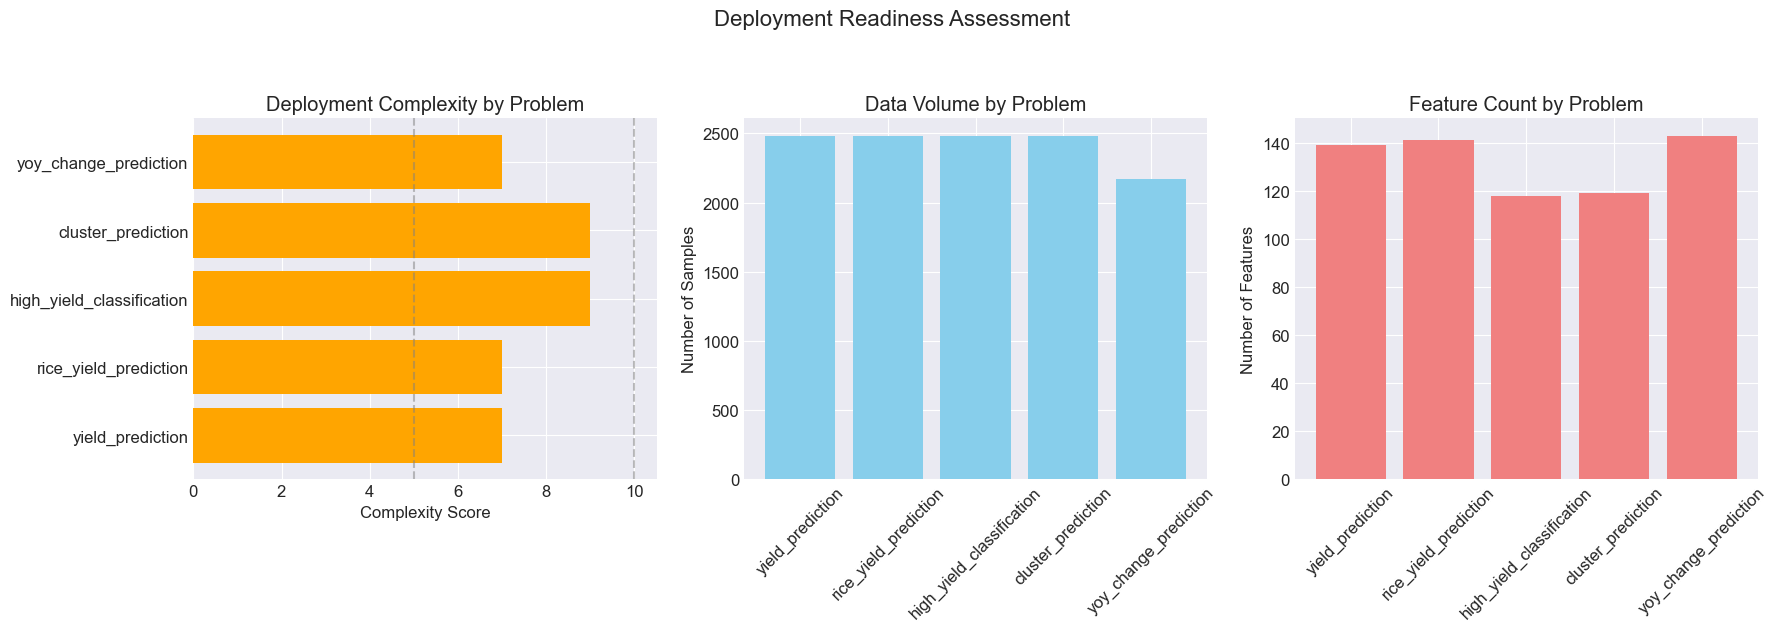


DEPLOYMENT READINESS REPORT

Overall Assessment:
  • Total Problems: 5
  • Overall Complexity: Medium
  • Readiness Score: 70/100

Problem Type Distribution:
  • regression: 3 problem(s)
  • classification: 1 problem(s)
  • multiclass: 1 problem(s)

Detailed Timeline Estimates:

  yield_prediction:
    • Data Preparation: 2 weeks
    • Model Development: 3 weeks
    • Testing: 2 weeks
    • Deployment: 2 weeks
    • Total: 9 weeks

  rice_yield_prediction:
    • Data Preparation: 2 weeks
    • Model Development: 3 weeks
    • Testing: 2 weeks
    • Deployment: 2 weeks
    • Total: 9 weeks

  high_yield_classification:
    • Data Preparation: 2 weeks
    • Model Development: 3 weeks
    • Testing: 2 weeks
    • Deployment: 2 weeks
    • Total: 9 weeks

  cluster_prediction:
    • Data Preparation: 2 weeks
    • Model Development: 3 weeks
    • Testing: 2 weeks
    • Deployment: 2 weeks
    • Total: 9 weeks

  yoy_change_prediction:
    • Data Preparation: 2 weeks
    • Model Developmen

In [19]:

# 8. Preliminary Model Assessment for Deployment Planning


def assess_model_deployment_potential(ml_data, problems, n_features=20):
    """
    Assess models for deployment potential based on data characteristics
    and problem complexity
    """
    
    deployment_assessment = {}
    
    for prob_name, data_dict in ml_data.items():
        print(f"\n{'='*80}")
        print(f"Deployment Assessment for: {prob_name}")
        print(f"{'='*80}")
        
        X = data_dict['X']
        y = data_dict['y']
        problem_type = data_dict['problem_type']
        
        assessment = {
            'problem_type': problem_type,
            'data_characteristics': {},
            'deployment_complexity': {},
            'recommended_models': [],
            'challenges': []
        }
        
        # Data characteristics analysis
        assessment['data_characteristics']['n_samples'] = len(X)
        assessment['data_characteristics']['n_features_original'] = X.shape[1]
        
        # Feature type analysis
        categorical_cols = X.select_dtypes(include=['object', 'category']).columns
        numerical_cols = X.select_dtypes(include=[np.number]).columns
        
        assessment['data_characteristics']['n_categorical'] = len(categorical_cols)
        assessment['data_characteristics']['n_numerical'] = len(numerical_cols)
        
        # Missing value analysis
        missing_percentage = X.isnull().sum().sum() / (X.shape[0] * X.shape[1]) * 100
        assessment['data_characteristics']['missing_percentage'] = missing_percentage
        
        # Target variable analysis
        if problem_type == 'regression':
            target_stats = {
                'mean': y.mean(),
                'std': y.std(),
                'skewness': y.skew(),
                'range': (y.min(), y.max())
            }
        else:
            target_stats = {
                'n_classes': len(np.unique(y)),
                'class_distribution': dict(y.value_counts(normalize=True).round(3))
            }
        
        assessment['data_characteristics']['target_stats'] = target_stats
        
        # Deployment complexity assessment
        # Score from 1 (simple) to 5 (complex)
        complexity_score = 0
        
        # Sample size complexity
        if len(X) < 1000:
            complexity_score += 1
            assessment['challenges'].append('Small sample size may limit model performance')
        elif len(X) < 10000:
            complexity_score += 2
        else:
            complexity_score += 3
        
        # Feature complexity
        if X.shape[1] < 10:
            complexity_score += 1
        elif X.shape[1] < 50:
            complexity_score += 2
        else:
            complexity_score += 3
            assessment['challenges'].append('High dimensionality requires feature selection')
        
        # Problem type complexity
        if problem_type == 'regression':
            complexity_score += 1
        elif problem_type == 'binary_classification':
            complexity_score += 2
        else:
            complexity_score += 3
        
        # Data quality complexity
        if missing_percentage > 20:
            complexity_score += 3
            assessment['challenges'].append('High missing data percentage requires imputation')
        elif missing_percentage > 5:
            complexity_score += 2
        else:
            complexity_score += 1
        
        assessment['deployment_complexity']['score'] = complexity_score
        
        if complexity_score <= 5:
            assessment['deployment_complexity']['level'] = 'Low'
        elif complexity_score <= 10:
            assessment['deployment_complexity']['level'] = 'Medium'
        else:
            assessment['deployment_complexity']['level'] = 'High'
        
        # Recommended models based on problem type and data characteristics
        if problem_type == 'regression':
            if len(X) < 1000:
                assessment['recommended_models'] = [
                    'Linear Regression',
                    'Ridge Regression',
                    'Decision Tree'
                ]
            else:
                assessment['recommended_models'] = [
                    'Random Forest',
                    'Gradient Boosting',
                    'XGBoost',
                    'LightGBM'
                ]
        
        elif problem_type == 'classification':
            if len(np.unique(y)) == 2:
                assessment['recommended_models'] = [
                    'Logistic Regression',
                    'Random Forest',
                    'XGBoost',
                    'LightGBM'
                ]
            else:
                assessment['recommended_models'] = [
                    'Random Forest',
                    'XGBoost',
                    'LightGBM',
                    'CatBoost'
                ]
        
        # Compute simple baseline model for reference
        print(f"\nData Characteristics:")
        print(f"  Samples: {assessment['data_characteristics']['n_samples']}")
        print(f"  Features: {assessment['data_characteristics']['n_features_original']}")
        print(f"  Numerical: {assessment['data_characteristics']['n_numerical']}")
        print(f"  Categorical: {assessment['data_characteristics']['n_categorical']}")
        print(f"  Missing: {assessment['data_characteristics']['missing_percentage']:.1f}%")
        
        print(f"\nTarget Analysis:")
        for key, value in target_stats.items():
            if isinstance(value, dict):
                print(f"  {key}:")
                for k, v in value.items():
                    print(f"    {k}: {v}")
            else:
                print(f"  {key}: {value}")
        
        print(f"\nDeployment Complexity: {assessment['deployment_complexity']['level']} (Score: {complexity_score})")
        
        if assessment['challenges']:
            print(f"\nChallenges Identified:")
            for challenge in assessment['challenges']:
                print(f"  • {challenge}")
        
        print(f"\nRecommended Models:")
        for model in assessment['recommended_models']:
            print(f"  • {model}")
        
        deployment_assessment[prob_name] = assessment
    
    return deployment_assessment

# Assess deployment potential
deployment_assessment = assess_model_deployment_potential(ml_data, problems)

# %% [markdown]
# ### 8.1 Create Deployment Readiness Report

# %%
def create_deployment_readiness_report(deployment_assessment):
    """
    Create a comprehensive deployment readiness report
    """
    
    report = {
        'summary': {
            'total_problems': len(deployment_assessment),
            'problem_types': {},
            'overall_complexity': 'Medium',
            'readiness_score': 0
        },
        'detailed_assessment': {},
        'recommendations': {},
        'timeline_estimates': {}
    }
    
    # Calculate overall statistics
    complexity_scores = []
    for prob_name, assessment in deployment_assessment.items():
        complexity_scores.append(assessment['deployment_complexity']['score'])
        
        # Track problem types
        prob_type = assessment['problem_type']
        if prob_type not in report['summary']['problem_types']:
            report['summary']['problem_types'][prob_type] = 0
        report['summary']['problem_types'][prob_type] += 1
    
    avg_complexity = np.mean(complexity_scores)
    if avg_complexity <= 5:
        report['summary']['overall_complexity'] = 'Low'
        readiness_score = 90
    elif avg_complexity <= 10:
        report['summary']['overall_complexity'] = 'Medium'
        readiness_score = 70
    else:
        report['summary']['overall_complexity'] = 'High'
        readiness_score = 50
    
    report['summary']['readiness_score'] = readiness_score
    
    # Detailed assessment for each problem
    for prob_name, assessment in deployment_assessment.items():
        report['detailed_assessment'][prob_name] = {
            'complexity_level': assessment['deployment_complexity']['level'],
            'complexity_score': assessment['deployment_complexity']['score'],
            'data_volume': assessment['data_characteristics']['n_samples'],
            'feature_count': assessment['data_characteristics']['n_features_original'],
            'key_challenges': assessment['challenges'],
            'recommended_approach': assessment['recommended_models']
        }
        
        # Generate specific recommendations
        recs = []
        
        if assessment['data_characteristics']['missing_percentage'] > 10:
            recs.append("Implement robust data imputation pipeline")
        
        if assessment['data_characteristics']['n_categorical'] > 10:
            recs.append("Use target encoding or embedding for categorical features")
        
        if assessment['data_characteristics']['n_features_original'] > 50:
            recs.append("Implement feature selection and dimensionality reduction")
        
        if assessment['data_characteristics']['n_samples'] < 1000:
            recs.append("Consider data augmentation or synthetic data generation")
        
        report['recommendations'][prob_name] = recs
        
        # Timeline estimates (in weeks)
        if assessment['deployment_complexity']['level'] == 'Low':
            timeline = {
                'data_preparation': 1,
                'model_development': 2,
                'testing': 1,
                'deployment': 1,
                'total': 5
            }
        elif assessment['deployment_complexity']['level'] == 'Medium':
            timeline = {
                'data_preparation': 2,
                'model_development': 3,
                'testing': 2,
                'deployment': 2,
                'total': 9
            }
        else:
            timeline = {
                'data_preparation': 3,
                'model_development': 4,
                'testing': 3,
                'deployment': 3,
                'total': 13
            }
        
        report['timeline_estimates'][prob_name] = timeline
    
    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Complexity scores
    problems = list(deployment_assessment.keys())
    scores = [deployment_assessment[p]['deployment_complexity']['score'] for p in problems]
    
    axes[0].barh(problems, scores, color=['green' if s <= 5 else 'orange' if s <= 10 else 'red' for s in scores])
    axes[0].set_xlabel('Complexity Score')
    axes[0].set_title('Deployment Complexity by Problem')
    axes[0].axvline(x=5, color='gray', linestyle='--', alpha=0.5)
    axes[0].axvline(x=10, color='gray', linestyle='--', alpha=0.5)
    
    # Data volume comparison
    volumes = [deployment_assessment[p]['data_characteristics']['n_samples'] for p in problems]
    axes[1].bar(problems, volumes, color='skyblue')
    axes[1].set_ylabel('Number of Samples')
    axes[1].set_title('Data Volume by Problem')
    axes[1].tick_params(axis='x', rotation=45)
    
    # Feature counts
    features = [deployment_assessment[p]['data_characteristics']['n_features_original'] for p in problems]
    axes[2].bar(problems, features, color='lightcoral')
    axes[2].set_ylabel('Number of Features')
    axes[2].set_title('Feature Count by Problem')
    axes[2].tick_params(axis='x', rotation=45)
    
    plt.suptitle('Deployment Readiness Assessment', fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()
    
    # Print report summary
    print("\n" + "="*80)
    print("DEPLOYMENT READINESS REPORT")
    print("="*80)
    
    print(f"\nOverall Assessment:")
    print(f"  • Total Problems: {report['summary']['total_problems']}")
    print(f"  • Overall Complexity: {report['summary']['overall_complexity']}")
    print(f"  • Readiness Score: {report['summary']['readiness_score']}/100")
    
    print(f"\nProblem Type Distribution:")
    for prob_type, count in report['summary']['problem_types'].items():
        print(f"  • {prob_type}: {count} problem(s)")
    
    print(f"\nDetailed Timeline Estimates:")
    for prob_name, timeline in report['timeline_estimates'].items():
        print(f"\n  {prob_name}:")
        print(f"    • Data Preparation: {timeline['data_preparation']} weeks")
        print(f"    • Model Development: {timeline['model_development']} weeks")
        print(f"    • Testing: {timeline['testing']} weeks")
        print(f"    • Deployment: {timeline['deployment']} weeks")
        print(f"    • Total: {timeline['total']} weeks")
    
    # Save report
    report_filename = 'deployment_readiness_report.pkl'
    with open(report_filename, 'wb') as f:
        pickle.dump(report, f)
    
    print(f"\nReport saved to: {report_filename}")
    
    return report

# Generate deployment readiness report
deployment_report = create_deployment_readiness_report(deployment_assessment)

In [29]:
# 8.2 Train-Test Split and Cross-Validation Setup

# %%
def prepare_train_test_splits(selected_data, test_size=0.2, random_state=42):
    """
    Create train-test splits for all problems
    """
    
    splits = {}
    
    for prob_name, data_dict in selected_data.items():
        X = data_dict['X']
        y = data_dict['y']
        
        # Create train-test split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state,
            stratify=y if data_dict['problem_type'] in ['classification', 'multiclass'] else None
        )
        
        splits[prob_name] = {
            'X_train': X_train,
            'X_test': X_test,
            'y_train': y_train,
            'y_test': y_test,
            'feature_names': data_dict['feature_names'],
            'problem_type': data_dict['problem_type'],
            'fs_pipeline': data_dict['fs_pipeline']
        }
        
        print(f"{prob_name}:")
        print(f"  Train shape: {X_train.shape}, Test shape: {X_test.shape}")
        if data_dict['problem_type'] in ['classification', 'multiclass']:
            print(f"  Train target distribution: {np.unique(y_train, return_counts=True)[1]}")
    
    return splits

# Create splits
splits = prepare_train_test_splits(selected_data)



yield_prediction:
  Train shape: (1984, 30), Test shape: (497, 30)
rice_yield_prediction:
  Train shape: (1987, 30), Test shape: (497, 30)
high_yield_classification:
  Train shape: (1987, 30), Test shape: (497, 30)
  Train target distribution: [995 992]
cluster_prediction:
  Train shape: (1987, 30), Test shape: (497, 30)
  Train target distribution: [637 454 333 147 416]
yoy_change_prediction:
  Train shape: (1736, 30), Test shape: (434, 30)


In [ ]:
# 9.